Tutorial taken from [here](https://acesuit.github.io/ACEpotentials.jl/v0.6/literate_tutorials/smoothness_priors/) as of 2025-05-08.

In [1]:
cd("/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/")
import Pkg
Pkg.activate(".")

  Activating project at `/leonardo_work/Sis25_degironc_0/apol/aceconverge2025`


In [2]:
using ACEpotentials, LinearAlgebra, Plots, LaTeXStrings

In [3]:
rawdata, _, _ = ACEpotentials.example_dataset("Si_tiny")
datakeys = (energy_key = "dft_energy", force_key = "dft_force", virial_key = "dft_virial")

rcut = 6.0
r_nn = 2.3 # typical nearest neighbor distance

model = ACE1x.acemodel(
    elements = [:Si],
    order = 3,
    totaldegree = 12,
    rcut = rcut, r0 = r_nn,
    Eref = Dict("Si" => -158.54496821)
)

data = [AtomsData(at; datakeys..., v_ref = model.Vref) for at in rawdata]
A, Y, W = ACEfit.assemble(data, model.basis);

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (1052, 211).
[ Info:   - Beginning assembly with processor count:  1.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
[ Info:   - Assembly completed.
[ Info: Assembling full weight vector.
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [7]:
Pa2 = algebraic_smoothness_prior(model.basis; p=2)
Pa4 = algebraic_smoothness_prior(model.basis; p=4);
Pg  = gaussian_smoothness_prior( model.basis, σl = (2/r_nn)^2, σn = (0.5/r_nn)^2);

In [9]:
priors = Dict("Id" => I, "Algebraic(2)" => Pa2, "Algebraic(4)" => Pa4,"Gaussian" => Pg)
rmse = Dict()
pots = Dict()

for (prior_name, P) in priors
    print("Solving with ", prior_name, " prior ... ")

    # solve the regularized least squarese problem 
    Ã = Diagonal(W) * (A / P)
    ỹ = Diagonal(W) * Y
    c̃ = ACEfit.solve(ACEfit.BLR(; verbose=false), Ã, ỹ)["C"]
    ACE1x._set_params!(model, P \ c̃)

    # compute errors and store them for later use (don't print them here)
    errs = ACEpotentials.linear_errors(rawdata, model; verbose=false, datakeys...)
    rmse[prior_name] = errs["rmse"]["set"]["F"]
    pots[prior_name] = model.potential
    println(" force=rmse = ", rmse[prior_name])
end

Solving with Id prior ... 

┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


 force=rmse = 0.11561897685593324
Solving with Algebraic(4) prior ... 

┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


 force=rmse = 0.12078924158033706
Solving with Gaussian prior ... 

┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


 force=rmse = 0.14547020962134175
Solving with Algebraic(2) prior ... 

┌ Warning: x_tol is deprecated. Use x_abstol or x_reltol instead. The provided value (1.0e-8) will be used as x_abstol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:110


 force=rmse = 0.11439130903690221


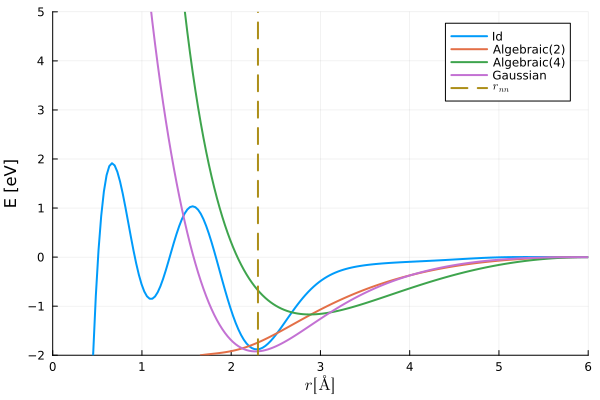

In [10]:
labels = sort(collect(keys(priors)))[[4,1,2,3]]
plt_dim = plot(
    legend = :topright, 
    xlabel = L"r [\AA]", ylabel = "E [eV]",
    xlims = (0,rcut), ylims = (-2, 5))

for l in labels
    D = ACEpotentials.dimers(pots[l], [:Si,])
    plot!(plt_dim, D[(:Si, :Si)]..., label = l, lw=2)
end
vline!([r_nn,], lw=2, ls=:dash, label = L"r_{\rm nn}")
plt_dim

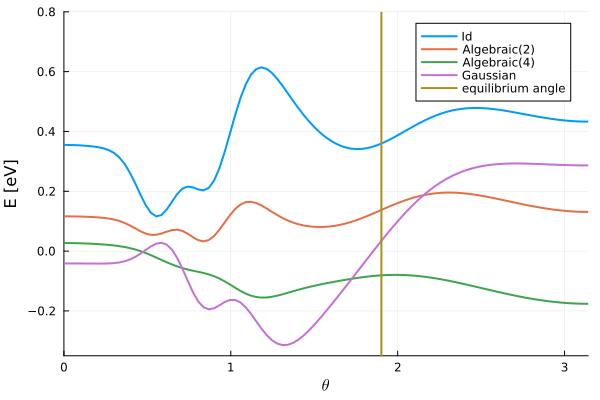

In [ ]:
# trimer case
plt_trim = plot(
    legend = :topright, xlabel = L"\theta", ylabel = "E [eV]",
    xlims = (0, pi), ylims = (-0.35, 0.8)
)

for l in labels
    D = ACEpotentials.trimers(pots[l], [:Si,], r_nn, r_nn)
    plot!(plt_trim, D[(:Si, :Si, :Si)]..., label = l, lw=2)
end

vline!(plt_trim, [1.90241,], lw=2, label = "equilibrium angle")
plt_trim

In [12]:
@doc ACEpotentials.dimer_energy

`function dimer_energy(pot, r, z1, z0)` : energy of a dimer  with separation `r` and atomic numbers `z1` and `z0` using the potential `pot`;  subtracting the 1-body contributions. 


In [13]:
@doc ACEpotentials.dimers

`dimers(potential, elements; kwargs...)` :  Generate a dictionary of dimer curves for a given potential. 

  * `potential` : potential to use to evaluate energy
  * `elements` : list of chemical species, symbols for which the dimers are to be computed

The function returns a dictionary `Ddim` such that `D[(s1, s2)]` contains pairs or arrays `(rr, E)` which can be plotted `plot(rr, E)`. 


┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (1.0e-32) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.305354e+03

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 2.03e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.71e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.68e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.35e-10 ≰ 1.0e-32
    |g(x)|                 = 2.78e-07 ≤ 1.0e-05

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    5
    ∇f(x) calls:   3

 * Status: success

 * Candidate solution
    Final objective value:     -1.305363e+03

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.02e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.87e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.26e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.68e-11 ≰ 1.0e-32
    |g(x)|                 = 4.53e-09 ≤ 1.0e-05

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations: 

┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (1.0e-32) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.305295e+03

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 1.38e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.53e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.18e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.67e-14 ≰ 1.0e-32
    |g(x)|                 = 3.24e-07 ≤ 1.0e-05

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    5
    ∇f(x) calls:   3



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (1.0e-32) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:120


 * Status: success

 * Candidate solution
    Final objective value:     -1.304991e+03

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 3.08e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.63e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.21e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.06e-14 ≰ 1.0e-32
    |g(x)|                 = 7.85e-07 ≤ 1.0e-05

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    5
    ∇f(x) calls:   3



┌ Warning: f_tol is deprecated. Use f_abstol or f_reltol instead. The provided value (1.0e-32) will be used as f_reltol.
└ @ Optim ~/.julia/packages/Optim/8dE7C/src/types.jl:120


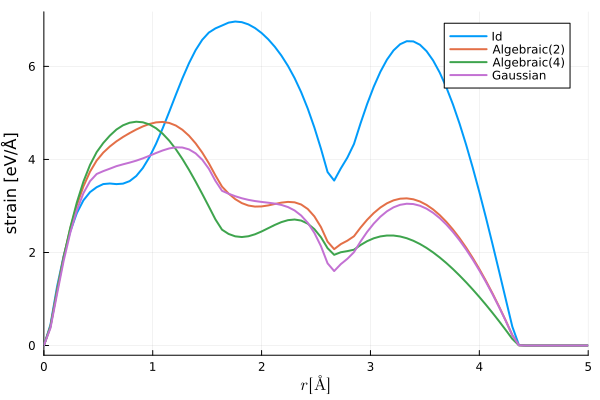

In [17]:
# Decohesion curve
at0 = bulk(:Si, cubic=true)
plt_dec = plot(legend =:topright, xlabel =L"r [\AA]", ylabel = "strain [eV/Å]", 
    xlim = (0.0, 5.0))

for l in labels
    aa, E, dE = ACEpotentials.decohesion_curve(at0, pots[l])
    plot!(plt_dec, aa, dE, label = l, lw=2)
end
plt_dec